In [307]:
import numpy as np 
np.set_printoptions(precision=4)
from scipy.stats import multivariate_normal as mvn
from tqdm import tqdm
from scipy.special import j1
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['axes.linewidth'] = 3
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.titlepad'] = 8.0
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.major.width'] = 3
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['lines.markersize'] = 5
mpl.rcParams['lines.linewidth'] = 5
mpl.rcParams['legend.fontsize'] = 15

In [308]:
# Define the target distribution
mean1 = np.array([0.35, 0.38])
cov1 = np.array([
    [0.01, 0.004],
    [0.004, 0.01]
])
w1 = 0.6

mean2 = np.array([0.68, 0.25])
cov2 = np.array([
    [0.005, -0.003],
    [-0.003, 0.005]
])
w2 = 0.2

mean3 = np.array([0.56, 0.64])
cov3 = np.array([
    [0.008, 0.0],
    [0.0, 0.004]
])

w3 = 0.1

mean4 = np.array([0.22, 0.74])
cov4 = np.array([
    [0.01, 0.004],
    [0.004, 0.01]
])
w4 = 0.1

def pdf(x):
    return w1 * mvn.pdf(x, mean1, cov1) + \
           w2 * mvn.pdf(x, mean2, cov2) + \
           w3 * mvn.pdf(x, mean3, cov3) + \
           w4 * mvn.pdf(x, mean4, cov4)
# Define a 1-by-1 2D search space
L_list = np.array([1.0, 1.0])  # boundaries for each dimension

# Discretize the search space into 100-by-100 mesh grids
num_grid = 100
grids_x, grids_y = np.meshgrid(
    np.linspace(0, L_list[0], num_grid),
    np.linspace(0, L_list[1], num_grid)
)
grids = np.array([grids_x.ravel(), grids_y.ravel()]).T
dx = 1.0 / (num_grid - 1)
dy = 1.0 / (num_grid - 1)

In [309]:
def barrier_and_grad(x, y, L, epsilon=1e-4):
    def soft_repel(s, Ls):
        return 1 / (s + epsilon) + 1 / (Ls - s + epsilon)
    
    def grad_soft_repel(s, Ls):
        return -1 / (s + epsilon)**2 + 1 / (Ls - s + epsilon)**2

    B = soft_repel(x, L[0]) + soft_repel(y, L[1])
    dBx = grad_soft_repel(x, L[0])
    dBy = grad_soft_repel(y, L[1])
    return B, np.array([dBx, dBy])

In [310]:
# Configure the index vectors
num_k_per_dim = 50
ks_dim1, ks_dim2 = np.meshgrid(
    np.arange(num_k_per_dim), np.arange(num_k_per_dim)
)
ks = np.array([ks_dim1.ravel(), ks_dim2.ravel()]).T
# Pre-processing lambda_k and h_k
#lamk_list = np.power(1.0 + np.linalg.norm(ks, axis=1), -3/2.0) # Fourier
lamk_list = np.ones(ks.shape[0]) # Radial, Indicator
hk_list = np.zeros(ks.shape[0])


# compute the coefficients for the target distribution Radial

## Radial
### Radial basis have the challenging tradeoff when too large they lack discrimination (in practice i.e finite in number)
### when too small they vanish almost everywhere and have poor generalization capabilities, that why we add usually 1 high variance rbf with lower weight to ensure stability of the algorithmn
sigmas = np.array([0.01,0.1,0.5]) ### Parameter of radial basis
weights = 1 / sigmas**2
weights /= np.sum(weights)
phik_list = np.zeros(ks.shape[0])  
pdf_vals = pdf(grids)
centers = np.zeros(ks.shape)
for i, k_vec in enumerate(ks):
    center = np.array([1 /(num_k_per_dim + 1) * (k_vec[0] + 1),  1/(num_k_per_dim + 1) * (k_vec[1] + 1)])
    centers[i] = center
    ## Try sum of radials for more stability
    sq_dists = np.sum((grids - center)**2, axis=-1)
    sigmas = np.array(sigmas).reshape(-1, 1)
    weights = np.array(weights).reshape(-1, 1)
    rbfs = np.exp(-sq_dists / (2 * sigmas**2))
    fk_vals = np.sum(weights * rbfs, axis=0)
    
    #fk_vals = np.exp(-(np.sum((grids - center)**2, axis = -1))/(2 * sigma**2))
    #print(fk_vals.shape)
    
    phik = np.sum(fk_vals * pdf_vals) * dx * dy
    phik_list[i] = phik

#### Smooth Indicator
"""alpha = 15
def sig(x,a, alpha = alpha):
    return 1 / (1 + np.exp(-alpha * (x - a)))

def d_sig(x, a, alpha = alpha):
    s = sig(x, a, alpha)
    return alpha * s * (1 - s)

lower = np.zeros(ks.shape)
upper = np.zeros(ks.shape)
phik_list = np.zeros(ks.shape[0])  
pdf_vals = pdf(grids)
for i, k_vec in enumerate(ks):
    a = np.array([1 /(num_k_per_dim) * (k_vec[0]),  1/(num_k_per_dim) * (k_vec[1])])
    b = np.array([1 /(num_k_per_dim) * (k_vec[0] + 1),  1/(num_k_per_dim) * (k_vec[1] + 1)])
    lower[i] = a
    upper[i] = b
    f1 = sig(grids,a)
    f2 = sig(grids,b)
    fk_vals = np.prod(f1 * (1 - f2), axis=-1)
    phik = np.sum(fk_vals * pdf_vals) * dx * dy
    phik_list[i] = phik"""

#Normalization Constant Fourier
# For gaussian sensor distribution Makes Cov = diag(var_1, var_2)
"""for i, k_vec in enumerate(ks):
    fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)  
    hk = np.sqrt(np.sum(np.square(fk_vals)) * dx * dy)
    hk_list[i] = hk
# compute the coefficients for the target distribution Fourier
phik_list = np.zeros(ks.shape[0])  
pdf_vals = pdf(grids)
for i, (k_vec, hk) in enumerate(zip(ks, hk_list)):
    fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)  
    fk_vals /= hk
    phik = np.sum(fk_vals * pdf_vals) * dx * dy 
    phik_list[i] = phik"""

'for i, k_vec in enumerate(ks):\n    fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)  \n    hk = np.sqrt(np.sum(np.square(fk_vals)) * dx * dy)\n    hk_list[i] = hk\n# compute the coefficients for the target distribution Fourier\nphik_list = np.zeros(ks.shape[0])  \npdf_vals = pdf(grids)\nfor i, (k_vec, hk) in enumerate(zip(ks, hk_list)):\n    fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)  \n    fk_vals /= hk\n    phik = np.sum(fk_vals * pdf_vals) * dx * dy \n    phik_list[i] = phik'

In [311]:
from scipy.spatial.distance import cdist
from numpy.linalg import solve
def safe_log_div(p, q):
    """Compute p * log(p / q) safely."""
    mask = (p > 0) & (q > 0)
    return np.sum(p[mask] * np.log(p[mask] / q[mask]))

def compare_pdfs(pdf1, pdf2, epsilon=1e-12):
    # Flatten and add epsilon
    p = pdf1.ravel().astype(float) + epsilon
    q = pdf2.ravel().astype(float) + epsilon ## empirical one

    # Normalize to sum to 1
    p /= np.sum(p)
    q /= np.sum(q)
    m = 0.5 * (p + q)

    results = {
        "L2 distance": np.linalg.norm(p - q),
        "Total Variation": 0.5 * np.sum(np.abs(p - q)),
        "KL(p || q)": safe_log_div(p, q),
        "KL(q || p)": safe_log_div(q, p),
        "Jensen-Shannon": 0.5 * (safe_log_div(p, m) + safe_log_div(q, m)),
        "Cosine similarity": np.dot(p, q) / (np.linalg.norm(p) * np.linalg.norm(q))
    }

    return results

def reconstruct_fourier(coeffs, hk_list, ks, grids):
    phi_recon = np.zeros(grids.shape[0])
    for i, (k_vec, ck, hk) in enumerate(zip(ks, coeffs, hk_list)):
        fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)
        fk_vals /= hk
        phi_recon += ck * fk_vals
    return phi_recon

def reconstruct_radial_basis(coeffs, weights, sigmas, centers, grids):
    M = centers.shape[0]
    N = sigmas.shape[0]
    d = centers.shape[1]
    pairwise_centers = cdist(centers, centers, 'sqeuclidean')  # shape (M, M)
    G = np.zeros((M, M))
    for i in range(N):
        for m in range(N):
            coef = (np.sqrt(np.pi) * np.sqrt(2 * sigmas[i]**2 * sigmas[m]**2 / (sigmas[i]**2 + sigmas[m]**2)))**d
            exp_term = np.exp(-pairwise_centers / (2 * (sigmas[i]**2 + sigmas[m]**2)))
            G += weights[i] * weights[m] * coef * exp_term
    rhs = np.zeros(M)
    for i in range(N):
        coef = (np.sqrt(np.pi) * np.sqrt(2) * sigmas[i])**d
        rhs += weights[i] * coef * coeffs
    c = np.linalg.solve(G + 1e-6 * np.eye(M), rhs)
    
    sq_dists = cdist(grids, centers, 'sqeuclidean')
    rbf_vals = np.zeros((grids.shape[0], M))
    for i in range(N):
        rbf_vals += weights[i] * np.exp(-sq_dists / (2 * sigmas[i]**2))
    
    phi_recon = rbf_vals @ c
    return phi_recon

def reconstruct_Indicator(coeffs):
    fks = np.zeros((grids.shape[0], len(ks)))
    for i,_ in enumerate(ks):
        f1 = sig(grids,lower[i])
        f2 = sig(grids,upper[i])
        fks[:, i] = np.prod(f1 * (1 - f2), axis=-1)

    # Compute Gram matrix and RHS vector
    G = fks.T @ (fks * dx * dy)
    # Solve for coefficients
    c = np.linalg.solve(G + 1e-6 * np.eye(G.shape[0]), coeffs)
    phi_recon = fks @ c
    return phi_recon
    
    

In [312]:
def barrier_and_grad(x, y, L, epsilon=1e-4):
    def soft_repel(s, Ls):
        return 1 / (s + epsilon) + 1 / (Ls - s + epsilon)
    
    def grad_soft_repel(s, Ls):
        return -1 / (s + epsilon)**2 + 1 / (Ls - s + epsilon)**2

    B = soft_repel(x, L[0]) + soft_repel(y, L[1])
    dBx = grad_soft_repel(x, L[0])
    dBy = grad_soft_repel(y, L[1])
    return B, np.array([dBx, dBy])

In [313]:
# Specify the dynamic system 
N_agents = 3
dt = 0.01
tsteps = 5001
ud = 0.2  # desired velocity 0.2 m/s
results_fourier = []

def dyn(xt, ut):
    xdot = ut 
    return ut

def step(xt, ut):
    xt_new = xt + dt * dyn(xt, ut)
    return xt_new 

phik_list *= N_agents
phik_list_expanded = np.repeat(phik_list[:, None], N_agents, axis=1) / N_agents
# start SMC iteration
xt = np.random.uniform(low=0.2, high=0.8, size=(2,N_agents)) # inital state
#xt = np.array([0.5,0.5]) # for fair comparison!
x_traj = np.zeros((tsteps, 2, N_agents)) # trajectory
ck_list_update = np.zeros((ks.shape[0], N_agents))  # trajectory coefficients (update over time, not normalized)
cK_lists = []
metric_log = []  # record ergodic metric at each step
timeit = []
M = phik_list.shape[0]
S_list = [np.zeros((M, M)) for _ in range(N_agents)]

for t in range(tsteps):

    barrier_weight = 0.0 #<- RBF
    B_val, dB = barrier_and_grad(xt[0,:], xt[1,:], L_list)


    rbfs = np.exp(-np.sum((xt[np.newaxis, :, :] - centers[:, :, np.newaxis])**2, axis=1) / (2 * (sigmas[:, np.newaxis]**2)))
    fk_xt_all = np.sum(weights[:, None] * rbfs, axis=0)


    """rbfs = np.exp(-(np.sum((xt[:,1] - centers)**2, axis = -1))/(2 * (sigmas.reshape(-1, 1))**2))
    fk_xt_all_test = np.sum(weights.reshape(-1, 1) * rbfs, axis=0)
    print(fk_xt_all[:,1].shape, fk_xt_all_test.shape)
    print(np.allclose(fk_xt_all[:,1], fk_xt_all_test))"""

    #fk_xt_all = np.prod(np.cos(np.pi * ks[:, :, None] / L_list[None, :, None] * xt[None, :, :]), axis=1) / hk_list[:, None]
    
    ck_list_update += fk_xt_all * dt

    # step 3: compute the derivative of all basis functions at the current state
    ## Radial basis multiple sigmas
    dfk_xt_all = np.zeros((*ks.shape, N_agents))  # Initialize

    for sigma, w in zip(sigmas, weights):
        diff = xt[np.newaxis, :, :] - centers[:, :, np.newaxis]  # (2500, 2, N_agents)
        coeff = -w * (sigma ** (-2))
        fk_exp = fk_xt_all[:, np.newaxis, :] 
        dfk_xt_all += coeff * diff * fk_exp
    dfk_xt_all = dfk_xt_all.transpose(1,0,2)

    """dfk_xt_all_test = np.zeros(ks.shape)
    for sigma, w in zip(sigmas, weights):
        dfk_xt_all_test += -w* (sigma**(-2) * (xt[:,1] - centers) * fk_xt_all_test[..., np.newaxis])
    dfk_xt_all_test = dfk_xt_all_test.T

    print(dfk_xt_all.shape, dfk_xt_all_test.shape)
    print(np.allclose(dfk_xt_all[:,:,1],dfk_xt_all_test))"""

    """dfk_xt_all = np.array([
        -np.pi * ks[:, 0, None] / L_list[0] * np.sin(np.pi * ks[:, 0, None] / L_list[0] * xt[0, None, :]) * np.cos(np.pi * ks[:, 1, None] / L_list[1] * xt[1, None, :]),
        -np.pi * ks[:, 1, None] / L_list[1] * np.cos(np.pi * ks[:, 0, None] / L_list[0] * xt[0, None, :]) * np.sin(np.pi * ks[:, 1, None] / L_list[1] * xt[1, None, :]),
    ]) / hk_list[:, None]"""
    #print(dfk_xt_all.shape, "Fourier")
    
    # step 4: compute control signal
    #print(ck_list_update.shape, phik_list.shape, dfk_xt_all.shape, lamk_list.shape)
    #S = lamk_list * (np.sum(ck_list_update / (t*dt + dt), axis = -1) - phik_list)
    #bt = np.sum(S[None, :, None] * dfk_xt_all, axis=1)
    #ut = -ud * bt / (np.linalg.norm(bt, axis=0) + 1e-8)

    bt = np.sum(lamk_list[:, None] * ((ck_list_update / (t*dt + dt)) - phik_list_expanded) * dfk_xt_all, axis=1) + barrier_weight * dB
    ut = -ud * bt / (np.linalg.norm(bt, axis=0) + 1e-8)
    # step 5: execute the control, move on to the next iteration
    xt = step(xt, ut)
    ## Update individual measures
    if t % 1 == 0:
        param = 0.001
        alpha = 0.3 * np.exp(-param * t)
        print(alpha)
        b_sum = np.sum(ck_list_update, axis=1, keepdims=True)  # shape [ks, 1]
        soft_target = phik_list[:, None] * ck_list_update / b_sum     # shape [ks, N_agents]
        phik_list_expanded = (1 - alpha) * phik_list_expanded + alpha * soft_target


        #diff = (ck_list_update / (t*dt + dt)) - phik_list_expanded 
        #grad_step = 2 * eta * lamk_list[:, None] * diff 
        #c_i_tilde = phik_list_expanded + grad_step
        #c_sum = np.sum(c_i_tilde, axis=1, keepdims=True)
        #correction = (c_sum - phik_list[:, None]) / N_agents 
        #phik_list_expanded = c_i_tilde - correction

    x_traj[t] = xt.copy()
    erg_metric = np.sum(np.square((np.sum(ck_list_update / (t*dt + dt), axis = -1) - phik_list)))
    metric_log.append(erg_metric)
    if t % 1000 == 0:     
        print(f"Step {t}, Position: {xt[:2,1]}, Metric: {erg_metric:.5f}")  

0.3
Step 0, Position: [0.3714 0.4335], Metric: 2.94039
0.2997001499500125
0.29940059960019993
0.2991013486510119
0.2988023968031974
0.2985037437578047
0.29820538921618056
0.2979073328799705
0.2976095744511182
0.2973121136318651
0.29701495012475043
0.2967180836326106
0.2964215138585791
0.29612524050608624
0.29582926327885856
0.29553358188091877
0.2952381960165855
0.29494310539047286
0.29464830970749023
0.2943538086728418
0.2940596019920266
0.29376568937083786
0.293472070515363
0.2931787451319831
0.29288571292737275
0.2925929736084998
0.2923005268826248
0.29200837245730105
0.291716510040374
0.2914249393399814
0.29113366006455244
0.29084267192280777
0.29055197462375926
0.2902615678767096
0.28997145139125197
0.28968162487726995
0.28939208804493693
0.289102840604716
0.2888138822673598
0.28852521274391
0.2882368317456969
0.28794873898433965
0.2876609341717453
0.28737341702010916
0.287086187241914
0.28679924454993
0.2865125886572144
0.28622621927711134
0.2859401361232514
0.28565433890955144
0

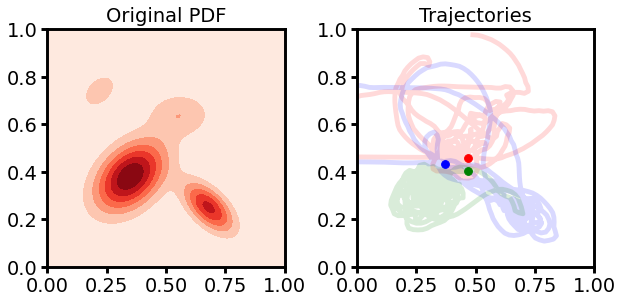

In [314]:
import matplotlib.cm as cm
fig, axes = plt.subplots(1, 2, figsize=(9,5), dpi=70, tight_layout=True)
#fig, axes = plt.subplots(figsize=(6, 4), dpi=100, tight_layout=True) #### For now only one plot as i do not wish to reconstruct.
ax = axes[0]
ax.set_aspect('equal')
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
ax.set_title('Original PDF')
ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='Reds')
distinct_colors = [
    'red', 'blue', 'green', 'orange', 'purple',
    'cyan', 'magenta', 'brown', 'olive', 'black',
    'pink', 'teal', 'navy', 'gold', 'lime',
    'coral', 'indigo', 'turquoise', 'maroon', 'gray'
]
ax = axes[1]
ax.set_title('Trajectories')
ax.set_aspect('equal')
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
for i in range(N_agents):
    color = distinct_colors[i % len(distinct_colors)]
    ax.plot(x_traj[::10, 0, i], x_traj[::10, 1, i], linestyle='-', marker='', color=color, alpha=0.15, label=f'Trajectory {i}')
    ax.plot(x_traj[0, 0, i], x_traj[0, 1, i], linestyle='', marker='o', markersize=8, color=color, alpha=1.0, label=f'Init {i}')
#ax.legend(loc=1)

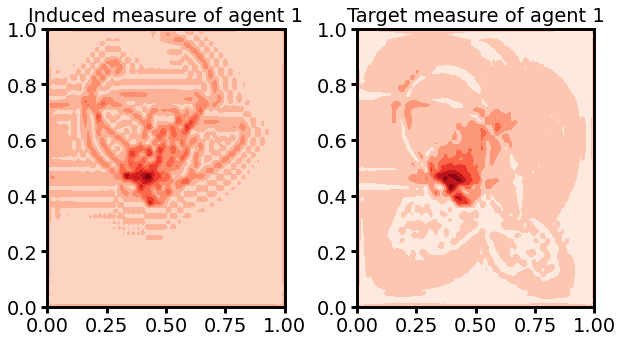

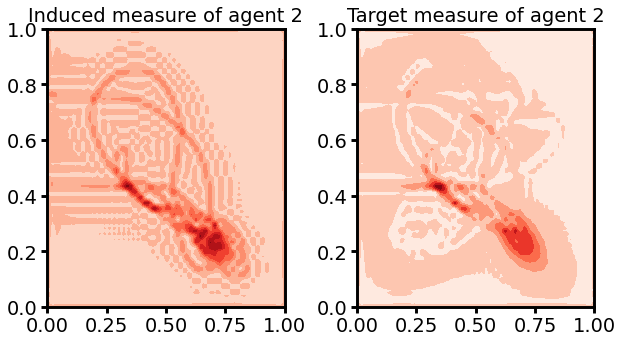

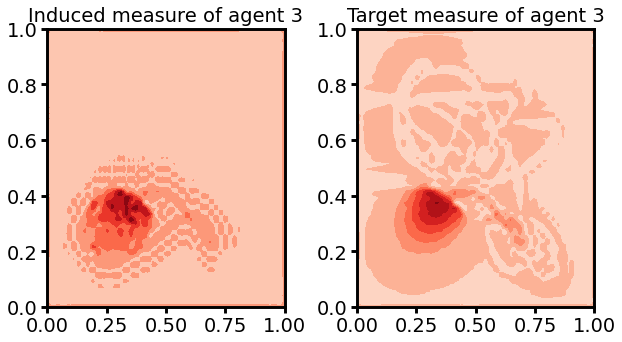

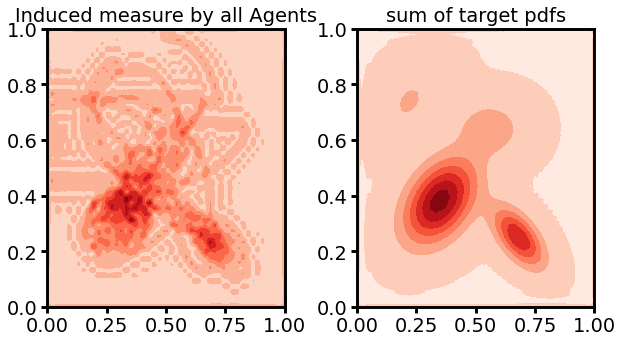

In [315]:
all_phi = np.zeros(grids.shape[0])
all_phi_target = np.zeros(grids.shape[0])
for agent in range(N_agents):
    M = centers.shape[0]
    N = sigmas.shape[0]
    d = centers.shape[1]
    pairwise_centers = cdist(centers, centers, 'sqeuclidean')  # shape (M, M)
    G = np.zeros((M, M))
    for i in range(N):
        for m in range(N):
            coef = (np.sqrt(np.pi) * np.sqrt(2 * sigmas[i]**2 * sigmas[m]**2 / (sigmas[i]**2 + sigmas[m]**2)))**d
            exp_term = np.exp(-pairwise_centers / (2 * (sigmas[i]**2 + sigmas[m]**2)))
            G += weights[i] * weights[m] * coef * exp_term
    
    rhs = np.zeros(M)
    rhs_target = np.zeros(M)
    for i in range(N):
        coef = (np.sqrt(np.pi) * np.sqrt(2) * sigmas[i])**d
        rhs += weights[i] * coef * ck_list_update[:,agent] / (tsteps * dt)
        rhs_target += weights[i] * coef * phik_list_expanded[:,agent]
    c = np.linalg.solve(G, rhs)
    c_target = np.linalg.solve(G, rhs_target)
    sq_dists = cdist(grids, centers, 'sqeuclidean')
    rbf_vals = np.zeros((grids.shape[0], M))
    for i in range(N):
        rbf_vals += weights[i] * np.exp(-sq_dists / (2 * sigmas[i]**2))
    phi_recon = rbf_vals @ c
    phi_recon_target = rbf_vals @ c_target
    all_phi += phi_recon
    all_phi_target += phi_recon_target
    fig, axes = plt.subplots(1, 2, figsize=(9,5), dpi=70, tight_layout=True)
    ax = axes[0]
    ax.set_xlim(0.0, L_list[0])
    ax.set_ylim(0.0, L_list[1])
    ax.set_title(f"Induced measure of agent {agent + 1}")
    ax.contourf(grids_x, grids_y, phi_recon.reshape(grids_x.shape), cmap='Reds')
    ax = axes[1]
    ax.set_xlim(0.0, L_list[0])
    ax.set_ylim(0.0, L_list[1])
    ax.set_title(f"Target measure of agent {agent + 1}")
    #print(phi_recon.sum(), phi_recon_target.sum())
    ax.contourf(grids_x, grids_y, phi_recon_target.reshape(grids_x.shape), cmap='Reds')
fig, axes = plt.subplots(1, 2, figsize=(9,5), dpi=70, tight_layout=True)
ax = axes[0]
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
all_phi /= N_agents
ax.set_title(f"Induced measure by all Agents")
ax.contourf(grids_x, grids_y, all_phi.reshape(grids_x.shape), cmap='Reds')
ax = axes[1]
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
ax.set_title(f"sum of target pdfs")
all_phi_target /= N_agents
ax.contourf(grids_x, grids_y, all_phi_target.reshape(grids_x.shape), cmap='Reds')


In [316]:
compare_pdfs(all_phi, pdf_vals)

{'L2 distance': 0.009279769046443818,
 'Total Variation': 0.27717408250122205,
 'KL(p || q)': 0.44391540430006665,
 'KL(q || p)': 0.07953801712040703,
 'Jensen-Shannon': 0.0987352108191745,
 'Cosine similarity': 0.9132973780203175}

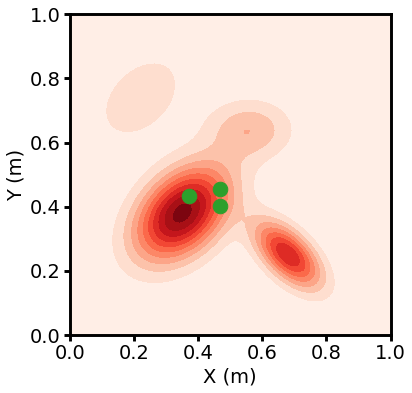

In [317]:
# Generate animation (takes about 1 minute)
from IPython.display import HTML
from matplotlib import animation

fig, ax = plt.subplots(1, 1, figsize=(6,7), dpi=70, tight_layout=True)
ax.set_aspect('equal')
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='Reds', levels=10)

robot_traj, = ax.plot([], [], linestyle='-', marker='', color='k', alpha=0.2)
robot_state, = ax.plot(x_traj[0,0], x_traj[0,1], linestyle='', marker='o', markersize=15, color='C2')

def update_plot(frame):
    t = int(frame * 10)
    robot_state.set_data(
        np.array([x_traj[t][0]]), np.array([x_traj[t][1]])
    )
    robot_traj.set_data(
        x_traj[:t,0][::10], x_traj[:t,1][::10]
    )

    return robot_state, robot_traj,

#ani = animation.FuncAnimation(fig, update_plot, frames=int(tsteps/10)-1, blit=True, interval=30, repeat=False)
#video = ani.to_html5_video()
#HTML(video)